<a href="https://colab.research.google.com/github/magesh73/project1/blob/master/Assignment10__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Build GradCam Images**

W0712 00:05:29.316397 139692483647360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 00:05:29.347352 139692483647360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 00:05:29.355388 139692483647360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 00:05:29.393449 139692483647360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 51s 0us/step


W0712 00:06:22.764595 139692483647360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0712 00:06:22.765940 139692483647360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



<bound method Network.summary of <keras.engine.training.Model object at 0x7f0c676d0fd0>>
40960/35363 [==================================] - 0s 0us/step
[[('n04356056', 'sunglasses', 0.32869634), ('n04355933', 'sunglass', 0.27461982), ('n04162706', 'seat_belt', 0.039859816), ('n03995372', 'power_drill', 0.03220846), ('n03763968', 'military_uniform', 0.019724498)]]
sunglasses (32.87%)
837


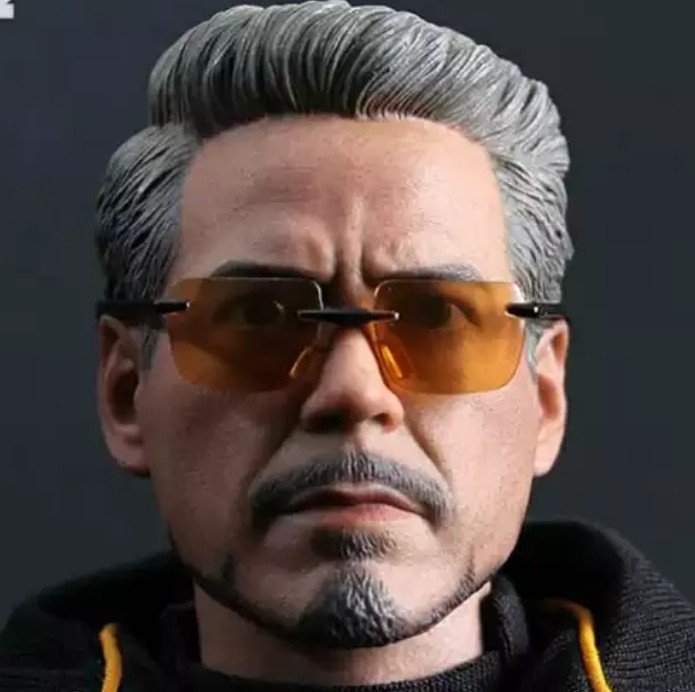

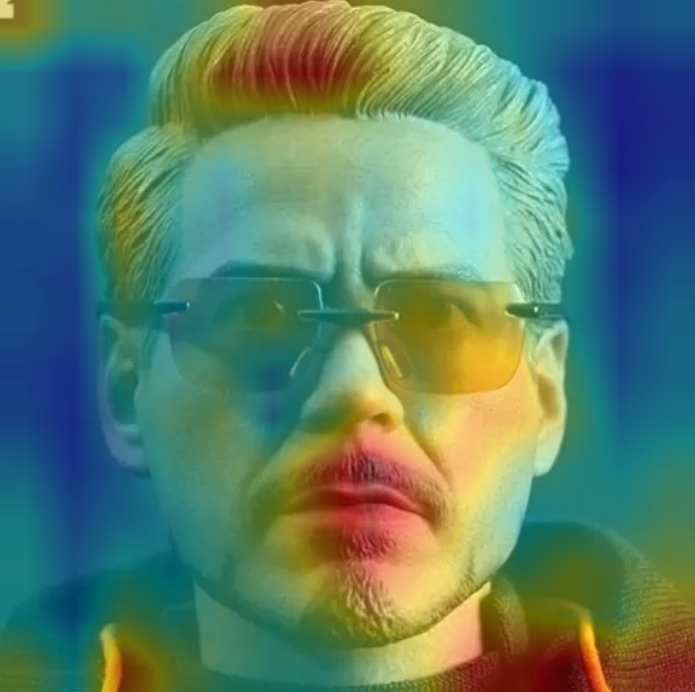

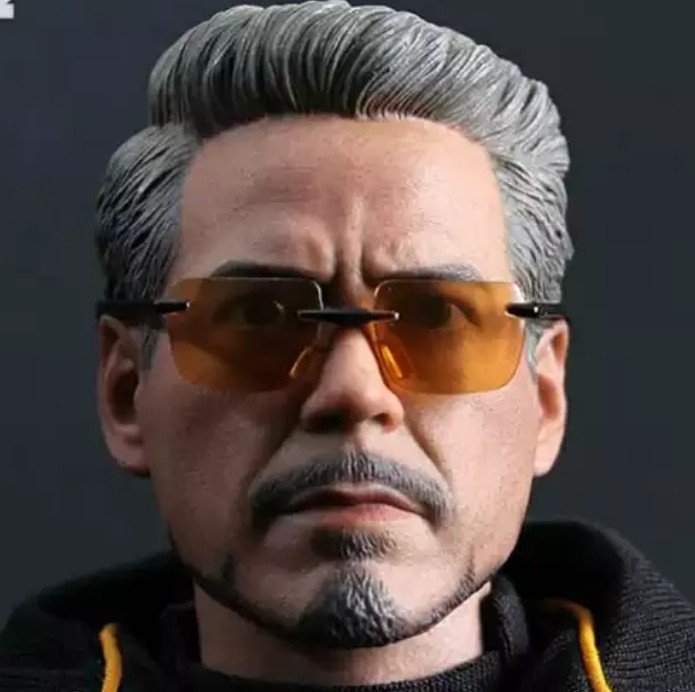

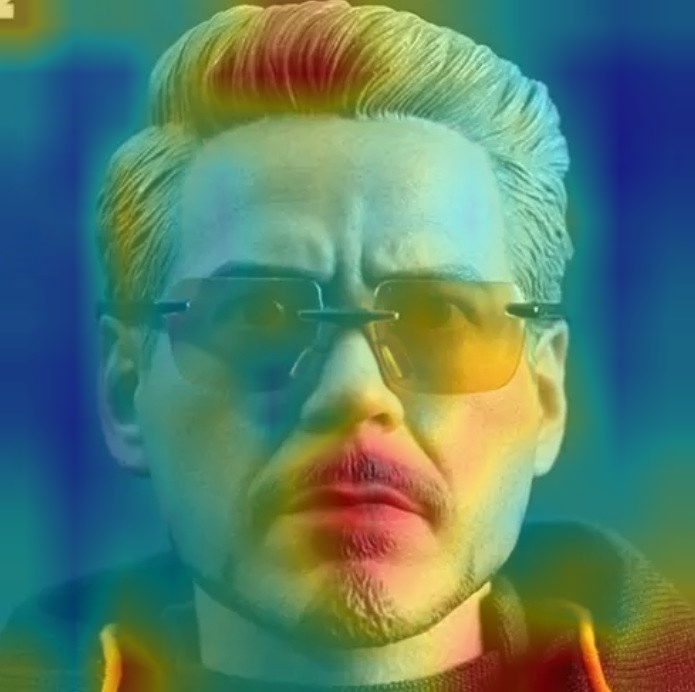

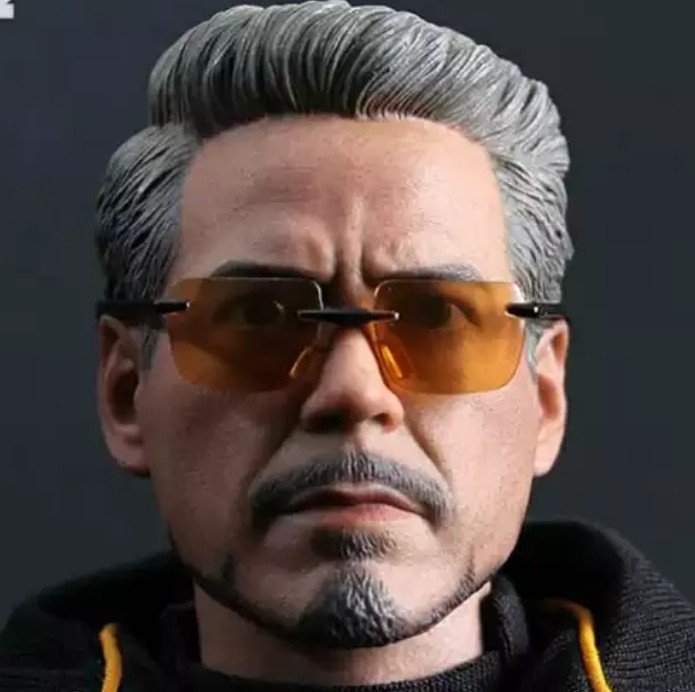

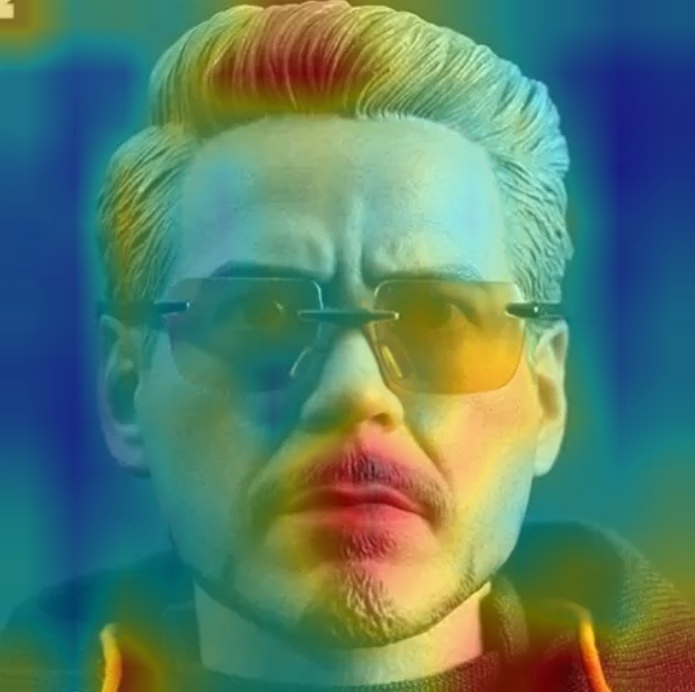

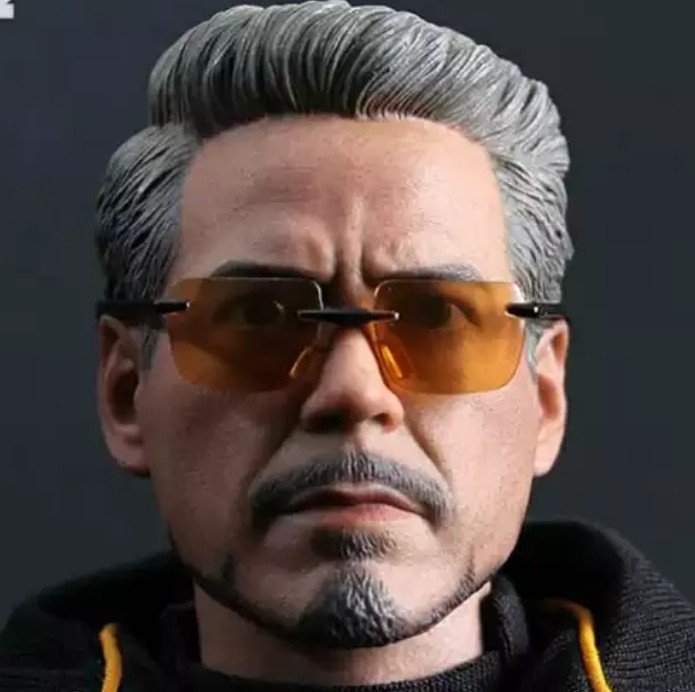

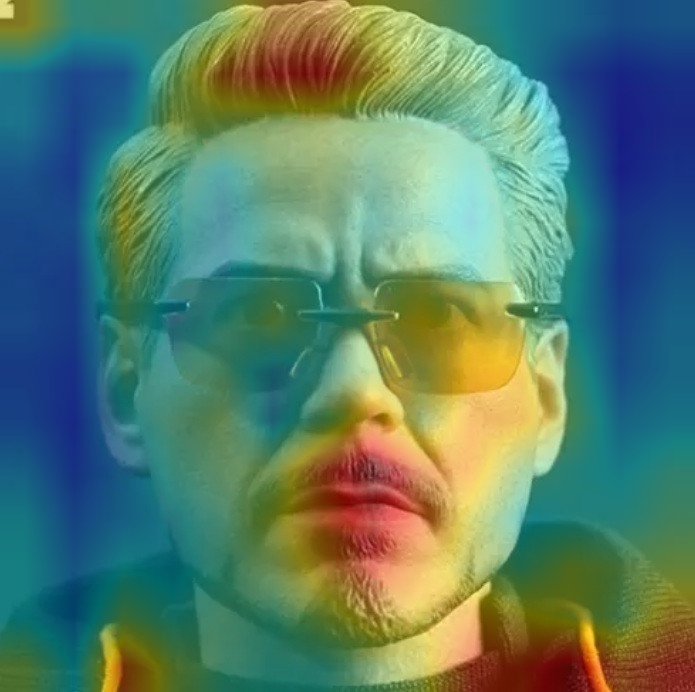

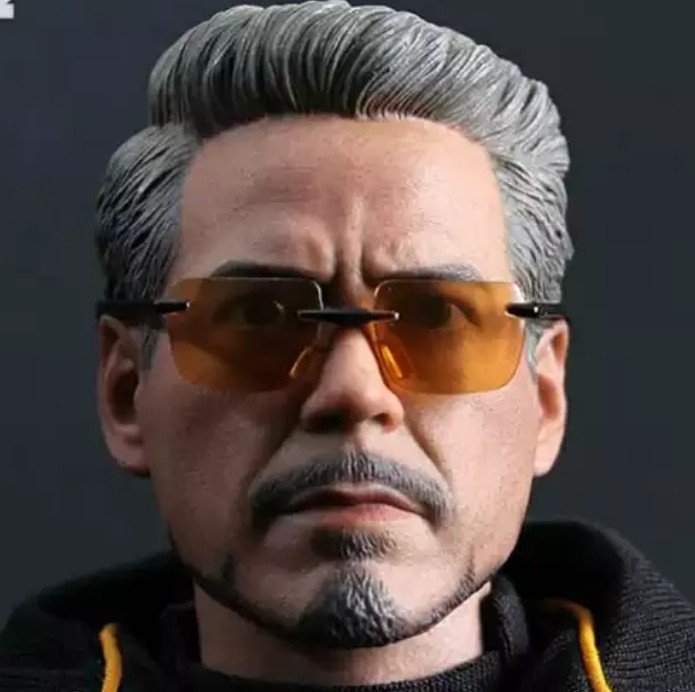

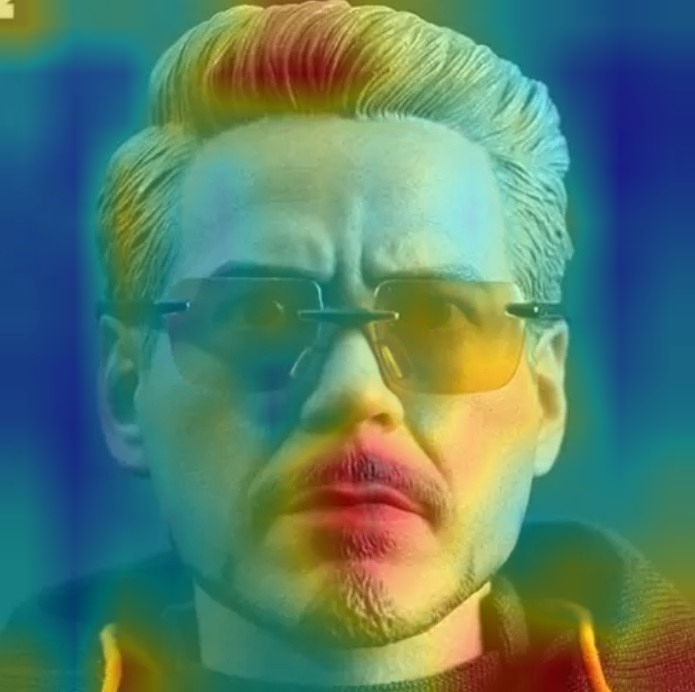

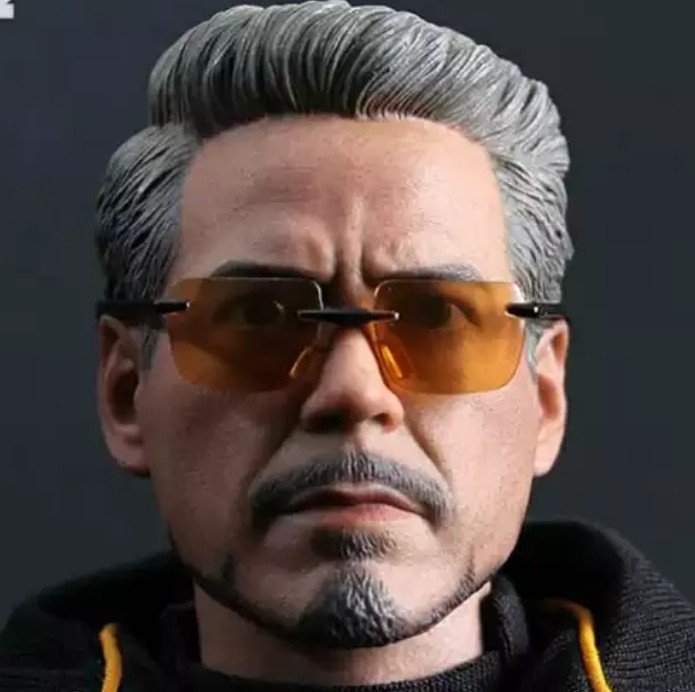

In [0]:
from keras.preprocessing.image import load_img
# load an image from file
image = load_img('/content/tony_stark.jpg', target_size=(224, 224))

getpredictionforModel(image,'VGG16')

In [0]:
def getpredictionforModel(image,modelname) :
   # convert the image pixels to a numpy array
  from keras.preprocessing.image import img_to_array
  from google.colab.patches import cv2_imshow
  import numpy as np
  import cv2
  import keras.backend as K
  
  image = img_to_array(image)
   # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
   # prepare the image for the VGG model
  from keras.applications.vgg16 import preprocess_input
  image = preprocess_input(image)
   # get the model
  if modelname == 'VGG16':
    from keras.applications.vgg16 import VGG16
    model = VGG16()
    print(model.summary)
  else:
    print('NO MODEL')
    return
    
     ##########################################################
   
  from keras.applications.vgg16 import decode_predictions
    # predict the probability across all output classes
  preds = model.predict(image)
 # convert the probabilities to class labels
  label = decode_predictions(preds)
  print(label)
 # retrieve the most likely result, e.g. highest probability
  label = label[0][0]
 # print the classification
  print('%s (%.2f%%)' % (label[1], label[2]*100))
  

  
  class_idx = np.argmax(preds[0])
  print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("block5_conv1")
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([image])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread('/content/tony_stark.jpg')
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    cv2_imshow(img)
    cv2_imshow(superimposed_img)
   

STEP BY STEP DOC

In [0]:

from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

Load and Prepare Image
Next, we can load the image as pixel data and prepare it to be presented to the network.
Keras provides some tools to help with this step.
First, we can use the load_img() function to load the image and resize it to the required size of 224×224 pixels.

In [0]:
from keras.preprocessing.image import load_img
# load an image from file

image = load_img('/content/033.JPG', target_size=(224, 224))
print(image)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7FA01BF7C7B8>


Next, we can convert the pixels to a NumPy array so that we can work with it in Keras. We can use the img_to_array() function for this.

In [0]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)


The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.
We only have one sample (one image). We can reshape the array by calling reshape() and adding the extra dimension.

In [0]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel.

In [0]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

Make a Prediction
We can call the predict() function on the model in order to get a prediction of the probability of the image belonging to each of the 1000 known object type

In [0]:
# predict the probability across all output classes
yhat = model.predict(image)

Interpret Prediction
Keras provides a function to interpret the probabilities called decode_predictions().
It can return a list of classes and their probabilities in case you would like to present the top 3 objects that may be in the photo.
We will just report the first most likely object.

In [0]:
from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
label = decode_predictions(yhat)
print(label)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

In [0]:
from keras.preprocessing.image import load_img
# load an image from file

image = load_img('/content/033.JPG', target_size=(224, 224))

getpredictionforModel(image,'VGG16')

In [0]:
def getpredictionforModel(image,modelname) :
   # convert the image pixels to a numpy array
  from keras.preprocessing.image import img_to_array
  image = img_to_array(image)
   # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
   # prepare the image for the VGG model
  from keras.applications.vgg16 import preprocess_input
  image = preprocess_input(image)
   # get the model
  if modelname == 'VGG16':
    from keras.applications.vgg16 import VGG16
    model = VGG16()
  else:
    print('NO MODEL')
    return
    
  # predict the probability across all output classes
  yhat = model.predict(image)
  
  from keras.applications.vgg16 import decode_predictions
 # convert the probabilities to class labels
  label = decode_predictions(yhat)
  
 # retrieve the most likely result, e.g. highest probability
  label = label[0][0]
 # print the classification
  print('%s (%.2f%%)' % (label[1], label[2]*100))

In [0]:
from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________